# **Data Analysis Notebook**

## Objectives

* This notebook will be used to test the dataset for use going forward

## Inputs

* We will use the BitCoinVsMacroNasdaq_v2 dataset saved within outputs/datasets/collection

## Outputs

* Create the train and test datasets from the cleaned and tested dataset

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [5]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [6]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [7]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# Analyse combined dataset

### Load the data

In [8]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/BitCoinVsMacroNasdaq_v2.csv"))
df.head()

,Date,Nasdaq_Close,Nasdaq_Volume,ExchangeRate,VIX,TEDSpread,Gold,Oil,M2_Money_Supply,10Y Treasury Yield,Fed Funds Rate,CPI,Inflation_Rate_%,SOFR,BitCoin_Close
0,2018-04-03,28.883333,4917300.0,1.2261,21.10,0.60,1332.800049,63.509998,13993.9,2.87,1.69,250.227,2.470996,1.83,7061.622526
1,2018-04-04,28.740000,3822600.0,1.2292,20.06,0.64,1335.800049,63.369999,13993.9,2.87,1.69,250.227,2.470996,1.74,7454.691790
2,2018-04-05,28.770000,3174300.0,1.2230,18.94,0.64,1324.300049,63.540001,13993.9,2.87,1.69,250.227,2.470996,1.75,6840.936110
3,2018-04-06,28.400000,2808000.0,1.2274,21.49,0.64,1331.900024,62.060001,13993.9,2.87,1.69,250.227,2.470996,1.75,6819.726657
4,2018-04-09,28.430000,1798200.0,1.2320,21.77,0.61,1336.300049,63.419998,13993.9,2.87,1.69,250.227,2.470996,1.75,7000.923355


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

Check BitCoin price history and distribution

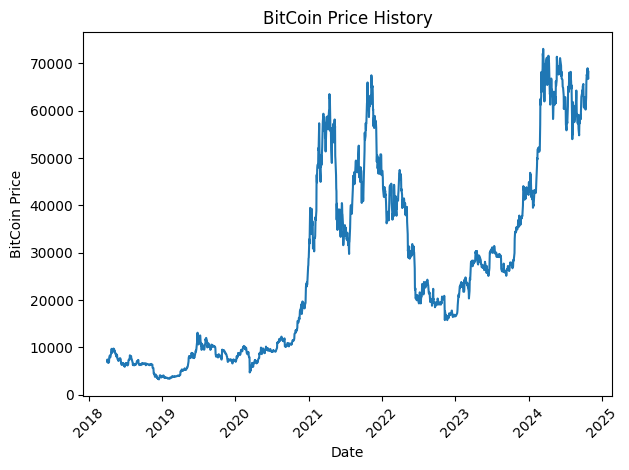

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x="Date", y="BitCoin_Close")

plt.title("BitCoin Price History")
plt.xlabel("Date")
plt.ylabel("BitCoin Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


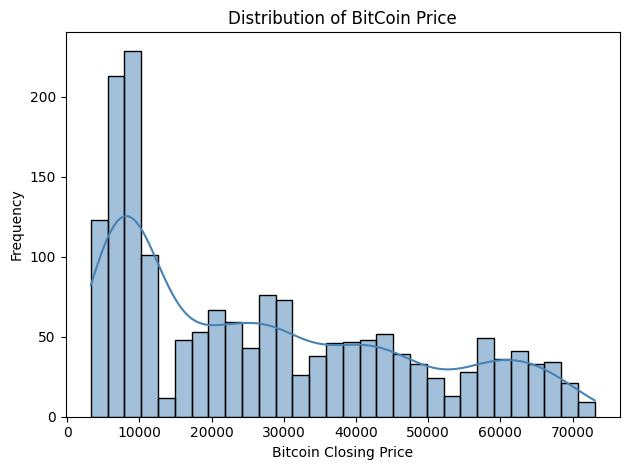

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x="BitCoin_Close", kde=True, bins=30, color="steelblue")

plt.title("Distribution of BitCoin Price")
plt.xlabel("Bitcoin Closing Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Perform correlation & PPS review

Ideally we would like to see correlated values above 0.70

In [18]:
corr_spearman = df.corr(method='spearman', numeric_only=True)['BitCoin_Close'].drop('BitCoin_Close').apply(abs).sort_values(ascending=False).head(10)
corr_spearman

Nasdaq_Close          0.846459
CPI                   0.805737
Gold                  0.788230
M2_Money_Supply       0.747256
TEDSpread             0.746727
Oil                   0.545569
Inflation_Rate_%      0.525562
10Y Treasury Yield    0.272312
ExchangeRate          0.155466
Fed Funds Rate        0.109809
Name: BitCoin_Close, dtype: float64

In [19]:
corr_pearson = df.corr(method='pearson', numeric_only=True)['BitCoin_Close'].drop('BitCoin_Close').apply(abs).sort_values(ascending=False).head(10)
corr_pearson

Nasdaq_Close          0.812017
Gold                  0.780432
M2_Money_Supply       0.737058
CPI                   0.675374
TEDSpread             0.494375
Oil                   0.458308
Inflation_Rate_%      0.342312
10Y Treasury Yield    0.309140
Fed Funds Rate        0.253337
SOFR                  0.244014
Name: BitCoin_Close, dtype: float64

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()

def CalculateCorrAndPPS(df):
    corr_spearman = df.corr(method="spearman", numeric_only=True)
    corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return corr_pearson, corr_spearman, pps_matrix

def DisplayCorrAndPPS(corr_pearson, corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    heatmap_corr(df=corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    heatmap_corr(df=corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [21]:
corr_pearson, corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min    25%    50%    75%  max
ppscore  210.0  0.453  0.377  0.0  0.038  0.434  0.836  1.0


/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt



*** Heatmap: Spearman Correlation ***


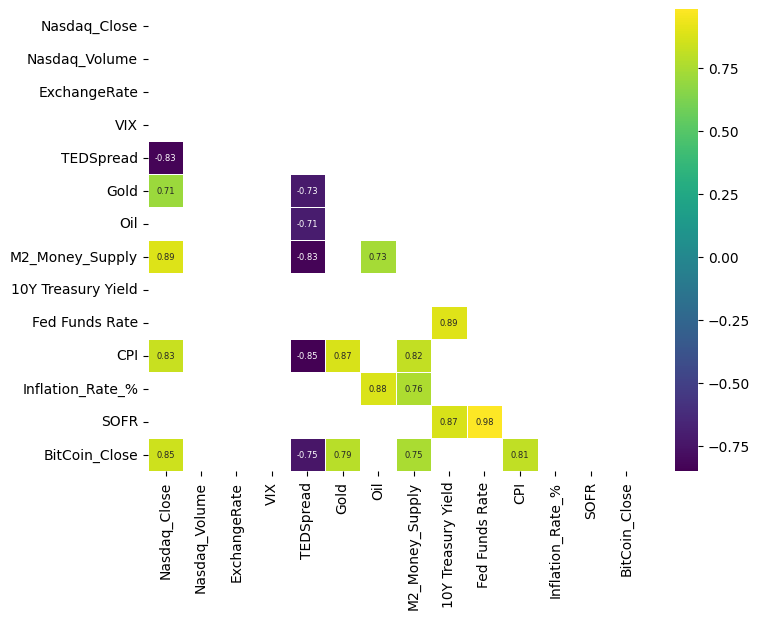



*** Heatmap: Pearson Correlation ***


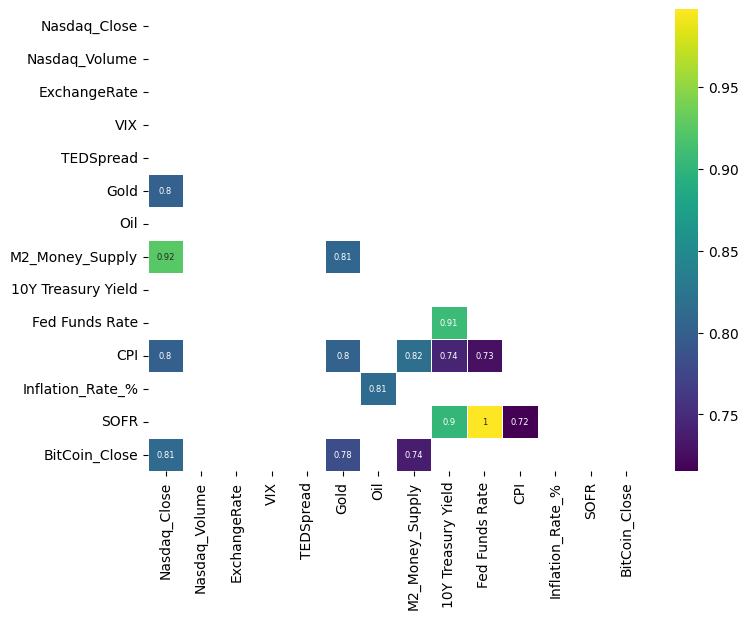



*** Heatmap: Power Predictive Score (PPS) ***


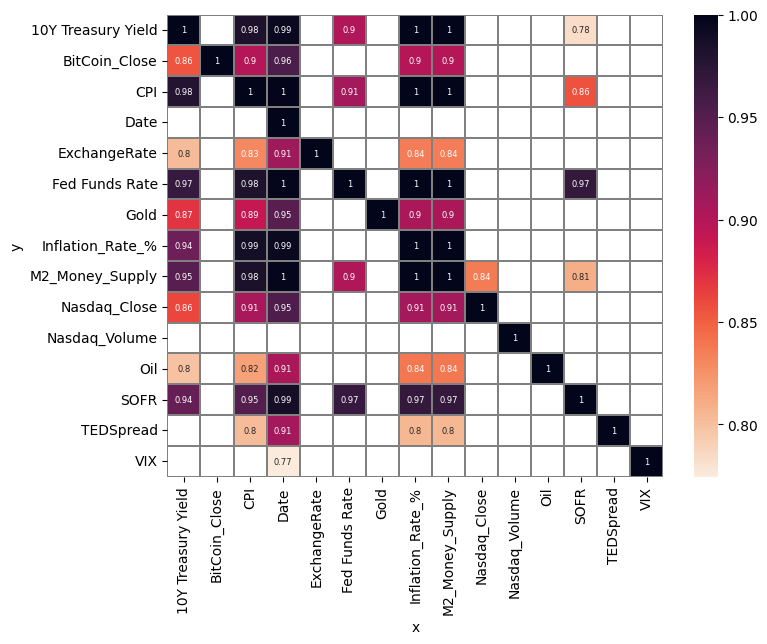

In [15]:
DisplayCorrAndPPS(corr_pearson = corr_pearson,
                  corr_spearman = corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.7, PPS_Threshold =0.75,
                  figsize=(8,6), font_annot=6)

## Correlation and PPS summary:

### Spearman
Under the Spearman monotonic relationship, the following observations are made:
* BitCoin seems to track the Nasdaq closely suggesting a strong correlation to tech stocks
* Inflation (CPI) and Money Supply (M2) have a strong correlation to BitCoin
* Gold is similar in movement to BitCoin
* TEDSpread (credit risk) suggests BitCoin may coincide with higher credit risk
* Correlated threshold was set to 0.70

### Pearson
Under the Pearson linear relationship, the following observations are made:
* BitCoin seems to track the Nasdaq closely suggesting a strong correlation to tech stocks
* Gold is similar in movement to BitCoin
* Inflation (CPI) and Money Supply (M2) have a strong correlation to BitCoin, albeit less than under Spearman
* Interestingly, TEDSpread is not as hightly correlated under the Pearson method
* Correlated threshold was set to 0.70

### PPS
The below were observed under Predictive Power Score:
* The upper quartile show some strong predictors
* The 10yr Treasury Yield, Inflation Rate & Money Supply (M2) scored the highest under PPS
* PPS threshold was set to 0.75 due to the upper quartile results

---

# Reduce dataset to only relevant features after analysis

Given that we only have a number of features that are highly correlated or have a high PPS, we will keep those moving forward and drop the others

In [22]:
df_cleaned = df[["Date", "BitCoin_Close", "Nasdaq_Close", "Gold", "Oil", "CPI", "Inflation_Rate_%", "M2_Money_Supply", "TEDSpread", "10Y Treasury Yield"]]
df_cleaned.head()

,Date,BitCoin_Close,Nasdaq_Close,Gold,Oil,CPI,Inflation_Rate_%,M2_Money_Supply,TEDSpread,10Y Treasury Yield
0,2018-04-03,7061.622526,28.883333,1332.800049,63.509998,250.227,2.470996,13993.9,0.60,2.87
1,2018-04-04,7454.691790,28.740000,1335.800049,63.369999,250.227,2.470996,13993.9,0.64,2.87
2,2018-04-05,6840.936110,28.770000,1324.300049,63.540001,250.227,2.470996,13993.9,0.64,2.87
3,2018-04-06,6819.726657,28.400000,1331.900024,62.060001,250.227,2.470996,13993.9,0.64,2.87
4,2018-04-09,7000.923355,28.430000,1336.300049,63.419998,250.227,2.470996,13993.9,0.61,2.87


---

# Push Train and Test datasets to the repo

Create the Outputs folder and save the Train and Test datasets in 'cleaned'

In [1]:
import os
try:
  os.makedirs(name='outputs/datasets/train_test_initial')
except Exception as e:
  print(e)

In [24]:
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"])
df_cleaned = df_cleaned.sort_values("Date")

In [25]:
# Lag target
df_cleaned["BTC_Close_Lag1"] = df_cleaned["BitCoin_Close"].shift(1)
df_cleaned["BTC_Close_RollingMean3"] = df_cleaned["BitCoin_Close"].rolling(window=3).mean()

# Lag market indices
df_cleaned["Nasdaq_Lag1"] = df_cleaned["Nasdaq_Close"].shift(1)

# Lag commodities
df_cleaned["Gold_Lag1"] = df_cleaned["Gold"].shift(1)
df_cleaned["Oil_Lag1"] = df_cleaned["Oil"].shift(1)

# Lag macroeconomic indicators
df_cleaned["CPI_Lag1"] = df_cleaned["CPI"].shift(1)
df_cleaned["Inflation_Lag1"] = df_cleaned["Inflation_Rate_%"].shift(1)
df_cleaned["M2_Lag1"] = df_cleaned["M2_Money_Supply"].shift(1)
df_cleaned["TEDSpread_Lag1"] = df_cleaned["TEDSpread"].shift(1)
df_cleaned["TreasuryYield_Lag1"] = df_cleaned["10Y Treasury Yield"].shift(1)

In [26]:
df_lagged = df_cleaned.dropna()

Split the dataset into Train and Test

In [27]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(
    df_lagged.drop(['BitCoin_Close', 'Date'], axis=1),
    df_lagged['BitCoin_Close'],
    test_size=0.2,
    shuffle=False,
    random_state=0
)

print(f"features_train shape: {features_train.shape} \nfeatures_test shape: {features_test.shape}")
print(f"target_train shape: {target_train.shape} \ntarget_test shape: {target_test.shape}")


features_train shape: (1369, 18) 
features_test shape: (343, 18)
target_train shape: (1369,) 
target_test shape: (343,)


Perform a final check on the train and test datasets for missing data

In [28]:
def check_missing_values(X_train, X_test, y_train, y_test):
    print('Missing Values Summary:\n')
    for name, df in zip(
        ['features_train', 'features_test', 'target_train', 'target_test'],
        [X_train, X_test, y_train, y_test]
    ):
        print(f"{name}:")
        print(df.isnull().sum())
        print()

check_missing_values(features_train, features_test, target_train, target_test)

Missing Values Summary:

features_train:
Nasdaq_Close              0
Gold                      0
Oil                       0
CPI                       0
Inflation_Rate_%          0
M2_Money_Supply           0
TEDSpread                 0
10Y Treasury Yield        0
BTC_Close_Lag1            0
BTC_Close_RollingMean3    0
Nasdaq_Lag1               0
Gold_Lag1                 0
Oil_Lag1                  0
CPI_Lag1                  0
Inflation_Lag1            0
M2_Lag1                   0
TEDSpread_Lag1            0
TreasuryYield_Lag1        0
dtype: int64

features_test:
Nasdaq_Close              0
Gold                      0
Oil                       0
CPI                       0
Inflation_Rate_%          0
M2_Money_Supply           0
TEDSpread                 0
10Y Treasury Yield        0
BTC_Close_Lag1            0
BTC_Close_RollingMean3    0
Nasdaq_Lag1               0
Gold_Lag1                 0
Oil_Lag1                  0
CPI_Lag1                  0
Inflation_Lag1            0
M2_Lag

In [29]:
features_train.to_csv("outputs/datasets/train_test_initial/features_train.csv", index=False)

In [30]:
features_test.to_csv("outputs/datasets/train_test_initial/features_test.csv", index=False)

In [31]:
target_train.to_csv("outputs/datasets/train_test_initial/target_train.csv", index=False)

In [32]:
target_test.to_csv("outputs/datasets/train_test_initial/target_test.csv", index=False)

We will also save the BitCoin price history, BitCoin distribution, Spearman and PPS heatmaps from above.

In [33]:
import os
try:
  os.makedirs(name='outputs/datasets/figs')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/figs'


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x="Date", y="BitCoin_Close")
plt.title("BitCoin Price History")
plt.xlabel("Date")
plt.ylabel("BitCoin Price")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("outputs/datasets/figs/bitcoin_price_history.png", dpi=300, bbox_inches='tight')
plt.close()


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x="BitCoin_Close", kde=True, bins=30, color="steelblue")

plt.title("Distribution of BitCoin Price")
plt.xlabel("Bitcoin Closing Price")
plt.ylabel("Frequency")
plt.tight_layout()

plt.savefig("outputs/datasets/figs/bitcoin_distribution.png", dpi=300, bbox_inches='tight')
plt.close()